In [19]:
#%matplotlib notebook
import numpy as np
import trimesh
from trimesh.exchange.binvox import voxelize_mesh
from tqdm import tqdm
import matplotlib.pyplot as plt
import pkg_resources

In [20]:
#mesh = trimesh.load_mesh(pkg_resources.resource_filename("quadrotor_project", "assets/drone_parcours.obj")) # FOR LINUX
mesh =  trimesh.load_mesh("drone_parcours.obj")

In [21]:
angel_voxel = mesh.voxelized(0.05)

In [22]:
angel_voxel.points

TrackedArray([[-0.5 ,  5.1 ,  1.  ],
              [-0.45,  5.1 ,  1.  ],
              [-0.4 ,  5.1 ,  1.  ],
              ...,
              [ 2.  ,  5.1 ,  1.  ],
              [ 2.05,  5.1 ,  1.  ],
              [ 2.1 ,  5.1 ,  1.  ]])

In [66]:
def plotgrid3D(grid):
    occupied_points = np.argwhere(grid == 1)
    x = occupied_points[:, 0]
    y = occupied_points[:, 1]
    z = occupied_points[:, 2]
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x, y, z, c='b', alpha =0.1)
    ax.set_aspect('equal')
    plt.show()

def plotgrid3Dwithmargin(grid, margin_grid):
    occupied_points = np.argwhere(grid == 1)
    x = occupied_points[:, 0]
    y = occupied_points[:, 1]
    z = occupied_points[:, 2]
    margin_occupied_points = np.argwhere(margin_grid == 1)
    margin_x = margin_occupied_points[:, 0]
    margin_y = margin_occupied_points[:, 1]
    margin_z = margin_occupied_points[:, 2]
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(margin_x, margin_y, margin_z, c='r', alpha =0.1)
    ax.scatter(x, y, z, c='b', alpha =0.1)
    
    ax.set_aspect('equal')
    plt.show()

def plotgrid2D(grid):
    occupied_points = np.argwhere(grid == 1)
    x = occupied_points[:, 0]
    y = occupied_points[:, 1]
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot()
    ax.scatter(x, y, c='b', alpha =0.5)
    ax.set_aspect('equal')
    plt.show()

def plotgrid2Dwithmargin(grid, margin_grid):
    occupied_points = np.argwhere(grid == 1)
    x = occupied_points[:, 0]
    y = occupied_points[:, 1]
    margin_occupied_points = np.argwhere(margin_grid == 1)
    margin_x = margin_occupied_points[:, 0]
    margin_y = margin_occupied_points[:, 1]
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot()
    ax.scatter(margin_x, margin_y, c='r', alpha =0.5)
    ax.scatter(x, y, c='b', alpha =0.5)
    ax.set_aspect('equal')
    plt.show()

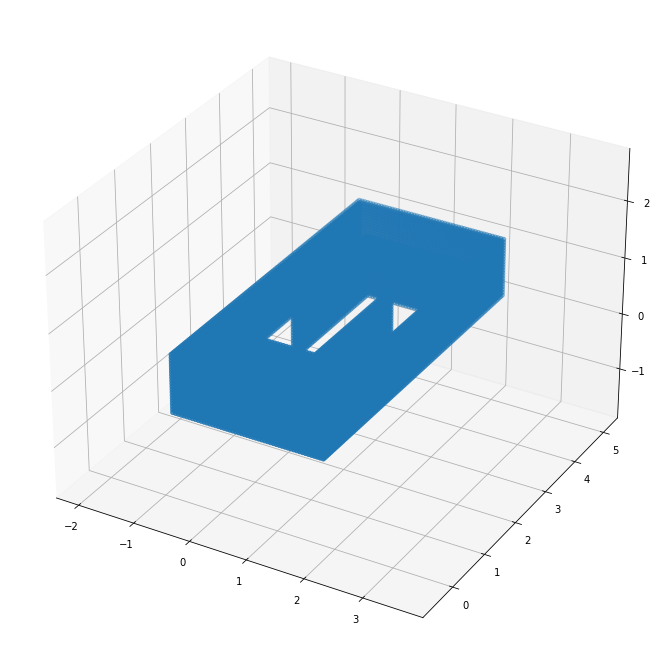

In [67]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(angel_voxel.points[:, 0], angel_voxel.points[:, 1],angel_voxel.points[:, 2])
ax.set_aspect('equal')
plt.show()

In [68]:
points = np.array(angel_voxel.points)
points.shape


(20412, 3)

In [69]:
xmin = min(angel_voxel.points[:, 0])
ymin = min(angel_voxel.points[:, 1])
zmin = min(angel_voxel.points[:, 2])
print(points.min(axis=0))

[-0.5 -0.5  0. ]


In [70]:
points[:, 0] -=xmin 
points[:, 1] -=ymin
points[:, 2] -=zmin

In [71]:
grid = np.zeros(shape=(len(np.unique(points[:,0])),len(np.unique(points[:,1])) , len(np.unique(points[:,2]))), dtype=np.int8)
grid.shape

points_max = points.max(axis = 0)
points_scaled = points/points_max*(np.asarray(grid.shape)-1)


In [72]:
for x,y,z in points_scaled:
    grid[round(x), round(y), round(z)] = 1
print(grid[-1,-1,-1])

1


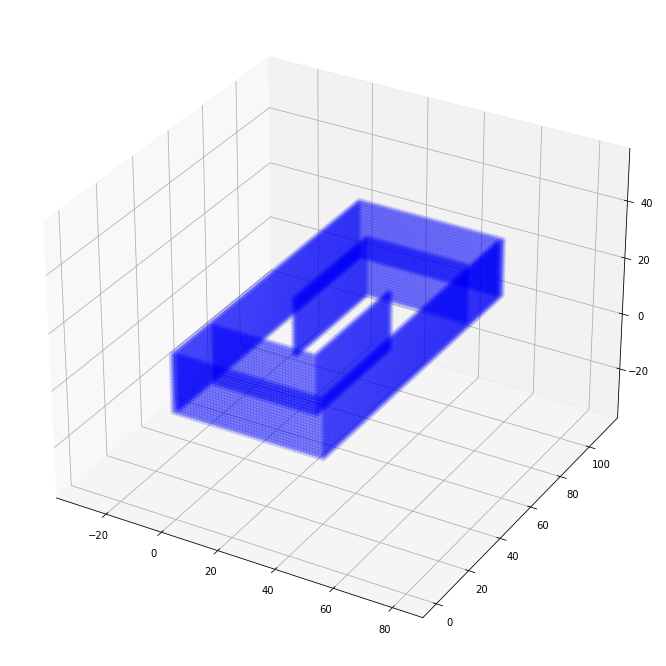

In [73]:
# # Testing occupancy map
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')

# for x in range(grid.shape[0]):
#     for y in range(grid.shape[1]):
#         for z in range(grid.shape[2]):
#             if grid[x, y, z] == 1:
#                 ax.scatter(x, y, z, c='b', alpha =0.5)
# ax.set_aspect('equal')
# plt.show()
plotgrid3D(grid)

In [74]:
grid2D = grid[: , : , 0]

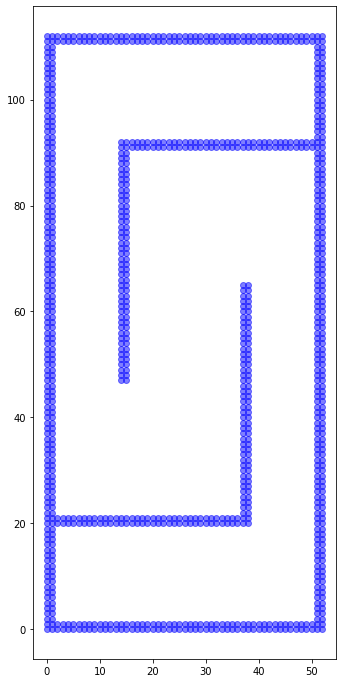

In [75]:
# Testing 2D occupancy map
plotgrid2D(grid2D)

In [76]:
#np.save('occupancygrid.npy', grid)

In [77]:
def checkneighbours2D(grid, x, y, xsize, ysize):
    if x-1 > 0 and grid[x-1][y] == 1: return True
    if y-1 > 0 and grid[x][y-1] == 1: return True
    if x+1 < xsize and grid[x+1][y] == 1: return True
    if y+1 < ysize and grid[x][y+1] == 1: return True
    return False
def checkneighbours3D(grid, x, y, z, xsize, ysize, zsize):
    if x-1 > 0 and grid[x-1][y][z] == 1: return True
    if y-1 > 0 and grid[x][y-1][z] == 1: return True
    if x+1 < xsize and grid[x+1][y][z] == 1: return True
    if y+1 < ysize and grid[x][y+1][z] == 1: return True
    if z-1 > 0 and grid[x][y][z-1] == 1: return True
    if z+1 < zsize and grid[x][y][z+1] == 1: return True
    return False
def marginise_grid2D(grid):
    newgrid =np.zeros(grid.shape, dtype=np.int8)
    xsize, ysize = grid.shape
    count = 0
    for x in range(xsize):
        for y in range(ysize):
            if checkneighbours2D(grid, x, y, xsize, ysize) or grid[x][y] == 1:
                newgrid[x][y] = 1
                count+=1
    print(f"Found {count} points")
    return newgrid
def marginise_grid3D(grid):
    newgrid =np.zeros(grid.shape, dtype=np.int8)
    xsize, ysize, zsize = grid.shape
    count = 0
    for x in range(xsize):
        for y in range(ysize):
            for z in range(zsize):
                if checkneighbours3D(grid, x, y, z, xsize, ysize, zsize) or grid[x][y][z] == 1:
                    newgrid[x][y][z] = 1
                    count+=1
    print(f"Found {count} points")
    return newgrid

In [78]:
m_grid2D = marginise_grid2D(grid2D)

Found 1602 points


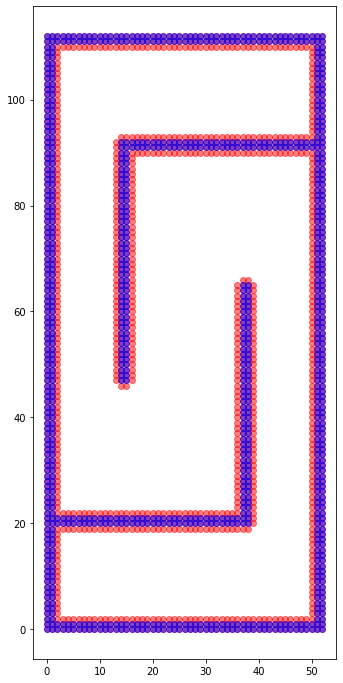

In [80]:
plotgrid2Dwithmargin(grid2D, m_grid2D)

In [18]:
m_grid2D.shape, grid2D.shape

((53, 113), (53, 113))

In [49]:
m_grid = marginise_grid3D(grid)

Found 33642 points


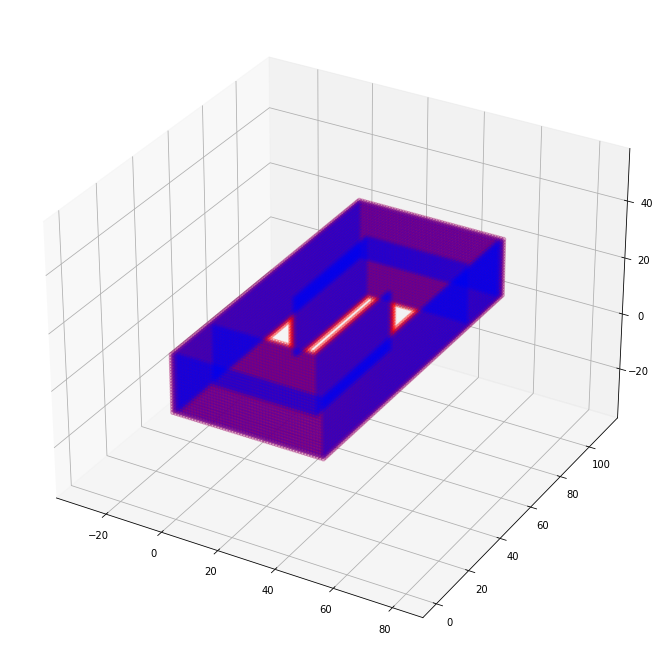

In [50]:
# Testing 3D occupancy map with margin
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')

# for x in range(grid.shape[0]):
#     for y in range(grid.shape[1]):
#         for z in range(grid.shape[2]):
#             if m_grid[x, y, z] == 1:
#                 ax.scatter(x, y, z, c='r', alpha =0.1)
#             if grid[x, y, z] == 1:
#                 ax.scatter(x, y, z, c='b', alpha =0.1)
# ax.set_aspect('equal')
# plt.show()
plotgrid3Dwithmargin(grid, m_grid)

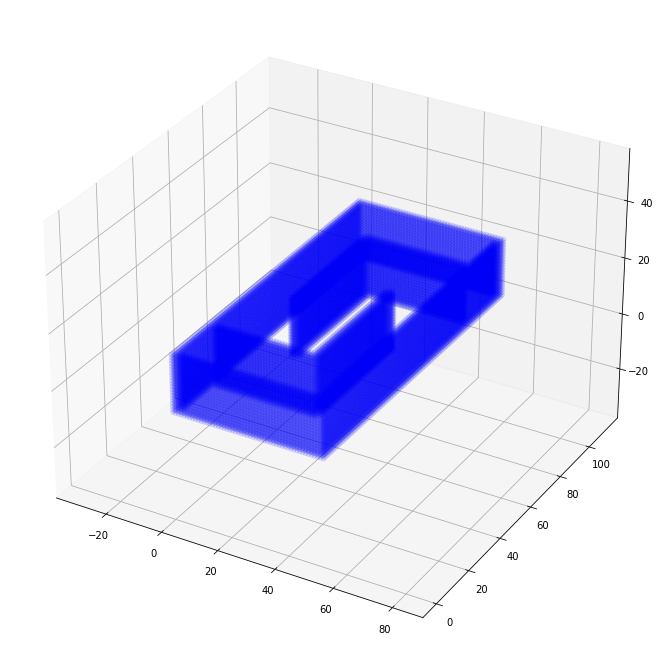

In [51]:
plotgrid3D(m_grid)